Imports needed to run the code

In [2]:
from IPython import display
import math
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

Importing in reddit API information

Put in your API information

In [3]:
import praw

reddit = praw.Reddit(client_id='',
                     client_secret='',
                     user_agent='')

Creating a set for headlines and populating the data based on whatever subreddit you choose

In [4]:
headlines = set()

In [5]:
for submission in reddit.subreddit('news').new(limit=None):
    headlines.add(submission.title)
    display.clear_output()
    print(len(headlines))

280


Using vader to generate a sentiment score for the different headlines

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[{'compound': -0.0258,
  'headline': 'Stabbed man saved by street surgery',
  'neg': 0.299,
  'neu': 0.412,
  'pos': 0.289},
 {'compound': 0.0,
  'headline': 'Record 26 Ebola deaths in DRCongo in a single day',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.4019,
  'headline': 'Christchurch trial: New Zealand media agree to curb white supremacy coverage',
  'neg': 0.0,
  'neu': 0.709,
  'pos': 0.291}]


Store the data as a dataframe and label the negative comments as -1 and positive comments as 1 based off a score cut off. 

In [7]:
df = pd.DataFrame.from_records(results)
df.head()

,compound,headline,neg,neu,pos
0,-0.0258,Stabbed man saved by street surgery,0.299,0.412,0.289
1,0.0000,Record 26 Ebola deaths in DRCongo in a single day,0.000,1.000,0.000
2,0.4019,Christchurch trial: New Zealand media agree to...,0.000,0.709,0.291
3,0.0000,Scientology Cruise Ship Quarantined Due to Mea...,0.000,1.000,0.000
4,0.0000,"Wyoming man allegedly stole from store, applie...",0.000,1.000,0.000


In [8]:
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.head()

,compound,headline,neg,neu,pos,label
0,-0.0258,Stabbed man saved by street surgery,0.299,0.412,0.289,0
1,0.0000,Record 26 Ebola deaths in DRCongo in a single day,0.000,1.000,0.000,0
2,0.4019,Christchurch trial: New Zealand media agree to...,0.000,0.709,0.291,1
3,0.0000,Scientology Cruise Ship Quarantined Due to Mea...,0.000,1.000,0.000,0
4,0.0000,"Wyoming man allegedly stole from store, applie...",0.000,1.000,0.000,0


In [9]:
df2 = df[['headline', 'label']]
df2.to_csv('reddit_headlines_labels.csv', mode='a', encoding='utf-8', index=False)

In [10]:
print("Positive headlines:\n")
pprint(list(df[df['label'] == 1].headline)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(df[df['label'] == -1].headline)[:5], width=200)

Positive headlines:

['Christchurch trial: New Zealand media agree to curb white supremacy coverage',
 'Private payrolls surge by 275,000 in April, blowing past estimates and the biggest gain since July',
 "US firm apologises for seeking 'preferably Caucasian' candidate",
 'Facebook Set to Create Privacy Positions as Part of F.T.C. Settlement',
 'Dog swallows £160 worth of £20 notes and costs owners £130 in vet bills']

Negative headlines:

['20 Indian students commit suicide after exam results',
 'Student expelled from Stanford in scandal paid $6.5 million to secure her admission - The Stanford Daily',
 'Venezuela braces for rival protests as crisis intensifies',
 'Doctor began CPR on California synagogue shooting victim unaware she was his wife',
 "Chase Bank deletes 'Monday Motivation' tweet after drawing social media outrage"]


In [11]:
print(df.label.value_counts())

print(df.label.value_counts(normalize=True) * 100)

-1    140
 0    107
 1     33
Name: label, dtype: int64
-1    50.000000
 0    38.214286
 1    11.785714
Name: label, dtype: float64


Create a bar graph to see the distribution of negative, neutral, and positive comments

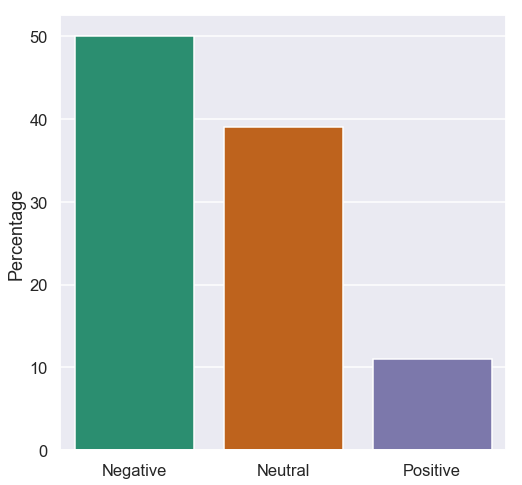

In [111]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [13]:
from nltk.tokenize import word_tokenize, RegexpTokenizer

example = "This is an example sentence! However, it isn't a very informative one"

print(word_tokenize(example, language='english'))

['This', 'is', 'an', 'example', 'sentence', '!', 'However', ',', 'it', 'is', "n't", 'a', 'very', 'informative', 'one']


In [14]:
tokenizer = RegexpTokenizer(r'\w+')
tokenizer.tokenize(example)

['This',
 'is',
 'an',
 'example',
 'sentence',
 'However',
 'it',
 'isn',
 't',
 'a',
 'very',
 'informative',
 'one']

In [15]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [16]:
def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

In [17]:
pos_lines = list(df[df.label == 1].headline)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('trump', 72),
 ('tax', 22),
 ('says', 17),
 ('barr', 15),
 ('sanders', 15),
 ('would', 13),
 ('medicare', 13),
 ('like', 13),
 ('2020', 12),
 ('warren', 11),
 ('bill', 10),
 ('house', 10),
 ('new', 10),
 ('approval', 9),
 ('people', 8),
 ('returns', 8),
 ('president', 8),
 ('u', 7),
 ('care', 7),
 ('security', 7)]

After removing stopwords and tokenizing the headlines, we create a word frequency distribution

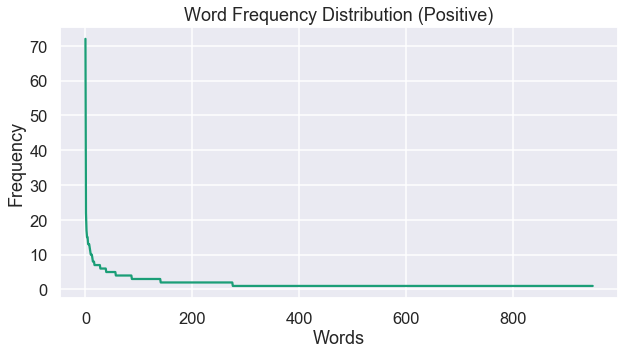

In [18]:
y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

We then plot it as log log to see its relation to zipfs law

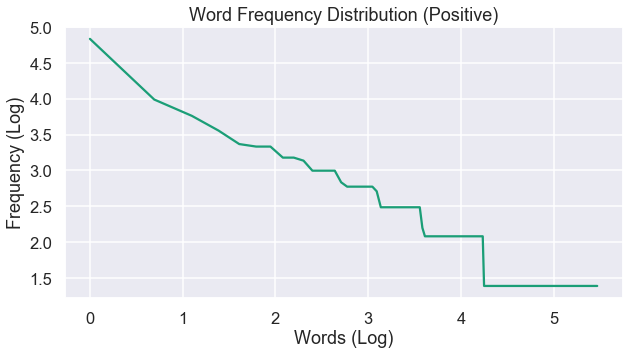

In [19]:
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

In [20]:
neg_lines = list(df2[df2.label == -1].headline)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

[('trump', 106),
 ('assange', 37),
 ('barr', 25),
 ('julian', 22),
 ('death', 21),
 ('arrested', 21),
 ('bill', 20),
 ('democrats', 18),
 ('white', 16),
 ('says', 16),
 ('house', 15),
 ('wikileaks', 15),
 ('omar', 15),
 ('us', 15),
 ('texas', 14),
 ('u', 14),
 ('crisis', 13),
 ('obama', 13),
 ('ilhan', 13),
 ('new', 13)]

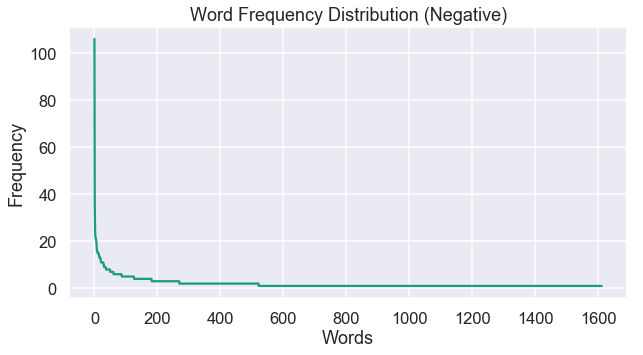

In [21]:
y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

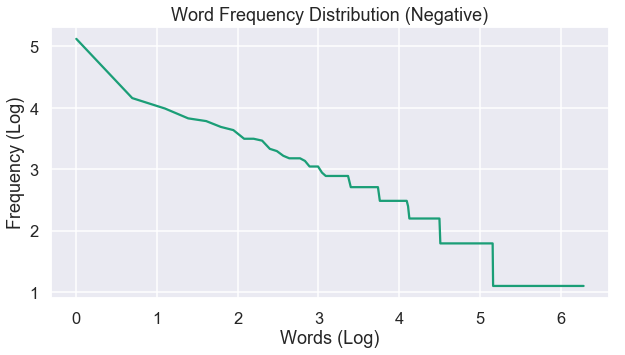

In [22]:
y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
    if i + k + z == 0:
        break
    y_final.append(math.log(i + k + z))

x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val, y_final)
plt.show()

The following code does the exact same thing as above but with comments from a particular post instead of the whole subreddit

In [12]:
submission = reddit.submission(id ='7xmtjj')

In [24]:
for top_level_comment in submission.comments:
    print(top_level_comment.body)

I think the thing that really got me was the one video where the SWAT comes into the classroom and all the students have their hands up. For a second you can see someone with their hands up shaking uncontrollably and I can almost understand how scared they were in that moment. Absolutely horrifying.
The screams in that video floating around are chilling. I hope there's adequate psychological services available for the survivors.
Parkland, FL was just named 15th in the top 100 safest cities to live in the U.S.

https://wsvn.com/news/local/two-broward-cities-ranked-among-nations-100-safest-communities/
The news media should voluntarily abstain from interviewing students if they cannot do a better job than this. The "How do you feel about being trapped inside your school while someone is shooting..." questions are ridiculous.
this is crazy just to think that people no different than me went to school and just got killed fucking horrible wtf has this world come to
[(NSFL) Students stuck in

AttributeError: 'MoreComments' object has no attribute 'body'

In [25]:
comments = set()

In [26]:
submission.comments.replace_more(limit=10)
for comment in submission.comments.list():
    comments.add(comment.body)
    display.clear_output()
    print(len(comments))

1370


In [27]:
sia = SIA()
results = []

for line in comments:
    pol_score = sia.polarity_scores(line)
    pol_score['comment'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[{'comment': 'I know none of the founding fathers wanted this.  They were afraid the government '
             "would try to seize weapons because they'd seen it before, and they were also "
             "suspicious of violent attacks since they didn't have a standing army.  The people "
             'were to protect themselves from Indians and anyone else they perceived to harm '
             "them.  I state repeatedly I have no issue with guns for self defense, they're cool "
             'tools.  But honestly, lets get some basic regulation done.',
  'compound': -0.8591,
  'neg': 0.196,
  'neu': 0.701,
  'pos': 0.103},
 {'comment': 'Nope. Reps got shot up at a baseball practice and no gun legislation came of it. ',
  'compound': -0.5574,
  'neg': 0.261,
  'neu': 0.739,
  'pos': 0.0},
 {'comment': 'Only if you consider NRA lobbying as a"gun control" of the government.',
  'compound': -0.0772,
  'neg': 0.106,
  'neu': 0.894,
  'pos': 0.0}]


In [28]:
df = pd.DataFrame.from_records(results)
df.head()

,comment,compound,neg,neu,pos
0,I know none of the founding fathers wanted thi...,-0.8591,0.196,0.701,0.103
1,Nope. Reps got shot up at a baseball practice ...,-0.5574,0.261,0.739,0.000
2,"Only if you consider NRA lobbying as a""gun con...",-0.0772,0.106,0.894,0.000
3,Do you know what the 2nd Amendment is?,0.0000,0.000,1.000,0.000
4,This really really sucks!,-0.5209,0.529,0.471,0.000


In [29]:
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.head()

,comment,compound,neg,neu,pos,label
0,I know none of the founding fathers wanted thi...,-0.8591,0.196,0.701,0.103,-1
1,Nope. Reps got shot up at a baseball practice ...,-0.5574,0.261,0.739,0.000,-1
2,"Only if you consider NRA lobbying as a""gun con...",-0.0772,0.106,0.894,0.000,0
3,Do you know what the 2nd Amendment is?,0.0000,0.000,1.000,0.000,0
4,This really really sucks!,-0.5209,0.529,0.471,0.000,-1


In [30]:
df2 = df[['comment', 'label']]
df2.to_csv('reddit_comments_labels.csv', mode='a', encoding='utf-8', index=False)

In [31]:
print("Positive comments:\n")
pprint(list(df[df['label'] == 1].comment)[:5], width=200)

print("\nNegative comments:\n")
pprint(list(df[df['label'] == -1].comment)[:5], width=200)

Positive comments:

['Apart from the gun debate, the US needs to solve a lot of other contributing factors. \n'
 '\n'
 '* Offer better and more available mental health therapy. \n'
 '\n'
 '* Reduce inequality so more people can live a happy life instead of working their asses of for little return. \n'
 '\n'
 '* Improve the prison system. Less people in prison leads to more money for mental health therapy or education and more people that will be able to earn money which makes them happy and generates '
 'tax money for even more education. Its like a happiness cycle vs a death spieal. \n'
 '\n'
 'In a nutshell: less angry people will result in less people shooting others. ',
 'I work at a large university, and our university police offers active shooter awareness classes to anyone who wants it.  The police will even come to a department to have the classes.  Would it be '
 'beneficial to have mandatory active shooter awareness classes at every high school the first week of school each s

In [32]:
print(df.label.value_counts())

print(df.label.value_counts(normalize=True) * 100)

-1    701
 1    348
 0    321
Name: label, dtype: int64
-1    51.167883
 1    25.401460
 0    23.430657
Name: label, dtype: float64


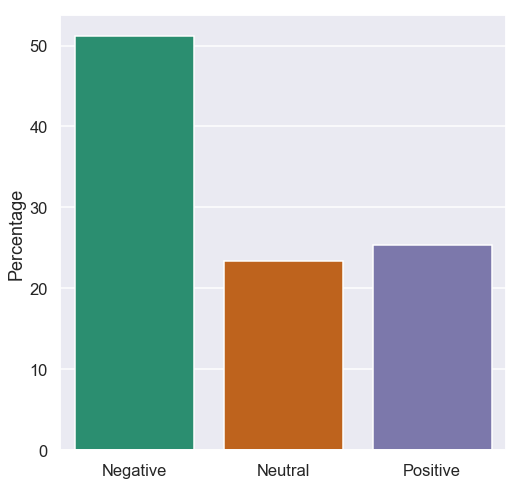

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

In [34]:
from nltk.tokenize import word_tokenize, RegexpTokenizer

example = "This is an example sentence! However, it isn't a very informative one"

print(word_tokenize(example, language='english'))

['This', 'is', 'an', 'example', 'sentence', '!', 'However', ',', 'it', 'is', "n't", 'a', 'very', 'informative', 'one']


In [35]:
tokenizer = RegexpTokenizer(r'\w+')
tokenizer.tokenize(example)

['This',
 'is',
 'an',
 'example',
 'sentence',
 'However',
 'it',
 'isn',
 't',
 'a',
 'very',
 'informative',
 'one']

In [36]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [37]:
def process_text(comments):
    tokens = []
    for line in comments:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

In [38]:
pos_lines = list(df[df.label == 1].comment)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('like', 99),
 ('people', 95),
 ('guns', 76),
 ('school', 71),
 ('gun', 66),
 ('would', 57),
 ('one', 50),
 ('shooting', 48),
 ('us', 46),
 ('need', 44),
 ('get', 40),
 ('know', 39),
 ('mass', 39),
 ('police', 37),
 ('way', 37),
 ('shootings', 36),
 ('well', 36),
 ('mental', 34),
 ('country', 34),
 ('every', 32)]

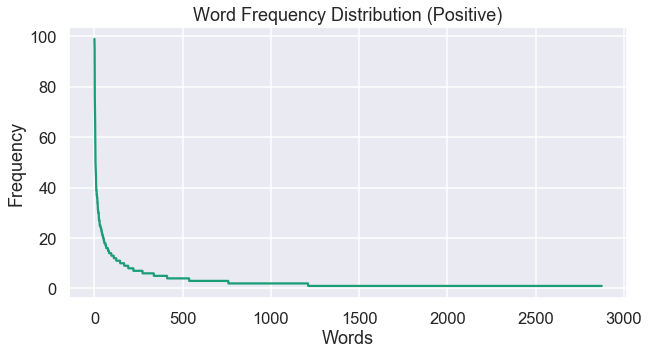

In [39]:
y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

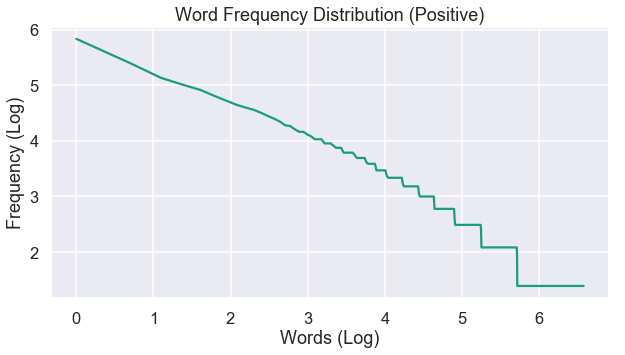

In [40]:
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

In [41]:
neg_lines = list(df2[df2.label == -1].comment)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

[('gun', 415),
 ('people', 327),
 ('guns', 245),
 ('school', 234),
 ('one', 160),
 ('would', 133),
 ('shooting', 131),
 ('like', 130),
 ('mental', 119),
 ('get', 118),
 ('shootings', 117),
 ('even', 111),
 ('think', 110),
 ('mass', 109),
 ('need', 103),
 ('us', 100),
 ('time', 87),
 ('health', 86),
 ('laws', 83),
 ('country', 81)]

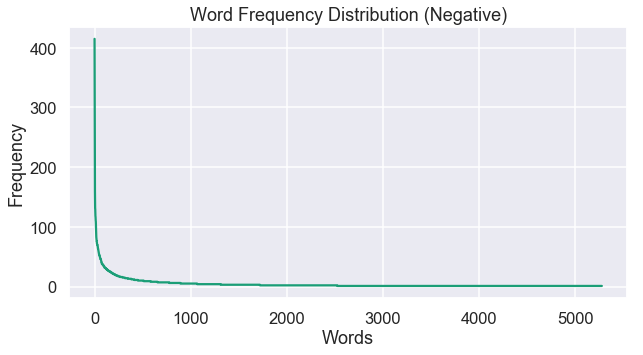

In [42]:
y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

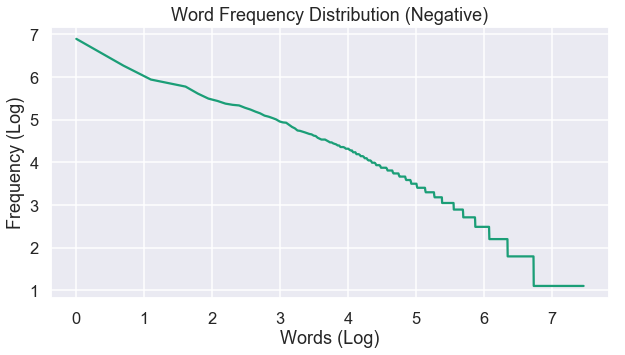

In [43]:
y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
    if i + k + z == 0:
        break
    y_final.append(math.log(i + k + z))

x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val, y_final)
plt.show()